# Libraries and preparation

refs:
- https://github.com/langchain-ai/langgraph/blob/main/examples/rag/langgraph_rag_agent_llama3_local.ipynb
- https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/agent_supervisor.ipynb?ref=blog.langchain.dev
- https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/hierarchical_agent_teams.ipynb?ref=blog.langchain.dev

MAP:REDUCE: https://langchain-ai.github.io/langgraph/how-tos/map-reduce/

In [1]:
import subprocess
import threading

#istallazione di ollama
!curl -fsSL https://ollama.com/install.sh | sh

>>> Downloading ollama...
######################################################################## 100.0%#=#=#                                                                          
>>> Installing ollama to /usr/local/bin...
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [2]:
def start_ollama():
    t = threading.Thread(target=lambda: subprocess.run(["ollama", "serve"]),daemon=True)
    t.start()

In [3]:
def pull_model(local_llm):
    !ollama pull local_llm

In [4]:
def start_model(local_llm):        
    t2 = threading.Thread(target=lambda: subprocess.run(["ollama", "run", local_llm]),daemon=True)
    t2.start()

In [131]:
%%capture --no-stderr
%pip install -U https://huggingface.co/d4data/en_pipeline/resolve/main/en_pipeline-any-py3-none-any.whl Dbias langchain-ai21 langchain-pinecone langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python nomic[local] langchain-text-splitters

In [6]:
# Tracing and api-keys
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["TAVILY_API_KEY"] = "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"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["PINECONE_API_KEY"] = "94ef7896-1fae-44d3-b8d2-0bd6f5f664f5"
os.environ["AI21_API_KEY"] = "KlINkh5QKw3hG1b5Hr75YDO7TwGoQvzn"

# Tools

refs:
- https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/

In [7]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

# Indexing

Organizing external sources for the llm. Phase of indexing and chunking of docs refs:
- https://python.langchain.com/v0.1/docs/modules/data_connection/document_loaders/
- https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/
- https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/recursive_text_splitter/
- Nomic embeddings: https://docs.nomic.ai/atlas/capabilities/embeddings#selecting-a-device

osservazione: si possono controllare gli indici direttamente da https://app.pinecone.io/organizations/-O2Tiw_0VD7HTOASPJE5/projects/2a95c518-e514-4d39-bed8-4b12fd90ad44/indexes

In [8]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_pinecone import PineconeVectorStore
from langchain_ai21 import AI21Embeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

def create_vectorstore(urls: list[str]):
    docs = [WebBaseLoader(url).load() for url in urls] #text + meta-data on docs
    docs_list = [item for sublist in docs for item in sublist] #ci serve l'attributo page_content

    # Chunking
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=250, chunk_overlap=0
    )

    doc_splits = text_splitter.split_documents(docs_list)
    index_name = "vectorstore"

    # Add to vectorDB
    vectorstore = PineconeVectorStore.from_documents(
        documents=doc_splits,
        #embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local", device="cuda"),
        embedding=AI21Embeddings(device="cuda"),
        index_name=index_name
    )
    return vectorstore.as_retriever()

# Indexing KBTs

In [9]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_pinecone import PineconeVectorStore
from langchain_ai21 import AI21Embeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


# metodo che permette di creare una lista di vectorstore
def create_KBTs(aspects, urls_list: list[list[str]]):
    retriever_list = []
    index=0
    for urls in urls_list:
        docs = [WebBaseLoader(url).load() for url in urls] #text + meta-data on docs
        docs_list = [item for sublist in docs for item in sublist] #ci serve l'attributo page_content

        # Chunking
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            chunk_size=250, chunk_overlap=0
        )

        doc_splits = text_splitter.split_documents(docs_list)
        index_name = f"{aspects[index].lower()}-kbt"
        
        #debug:
        #print(doc_splits)

        # Add to vectorDB
        vectorstore_KBT = PineconeVectorStore.from_documents(
            documents=doc_splits,
            #embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local", device="cuda"),
            embedding=AI21Embeddings(device="cuda"),
            index_name=index_name
        )
        retriever_KBT = vectorstore_KBT.as_retriever()
        retriever_list.append(retriever_KBT)
        index=index+1
    return retriever_list

# Query generation (multi-aspects)

In [72]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

def query_generator(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You have to generate multiple
        search queries based on some specified aspects. You have to generate an answer as a Python list,
        and in each position of the list there is the generated query of the aspect. NO PREAMBLE: return only the list.
        Here some examples:
        Original query: "What about COVID19?"
        Aspects: ["Health","Economy"]
        Answer: ["Symptoms of COVID19","Economic consequences of COVID19"]
        \n ----- \n
        Original query: "COVID19 was fake?"
        Aspects: ["Health","Society"]
        Answer: ["Is COVID19 just a cold?","What people think about COVID19?"]
        \n ----- \n
        <|eot_id|><|start_header_id|>user<|end_header_id|>
        Original query: {original_query}
        Aspects: {aspects}
        Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["aspects","original_query"],
    )
    llm = ChatOllama(model=local_llm, temperature=0) 
    query_generator = prompt | llm | StrOutputParser() 
    return query_generator


#original_query = "Covid19 was a hoax?"
#aspects = ["Health","Economy"]
#generation = query_generator(local_llm).invoke({"original_query": original_query, "aspects":aspects})
#print(eval(generation))


# # Reciprocal Rank Fusion algorithm
# def reciprocal_rank_fusion(search_results_dict, k=60):
#     fused_scores = {}
#     print("Initial individual search result ranks:")
#     for query, doc_scores in search_results_dict.items():
#         print(f"For query '{query}': {doc_scores}")

#     for query, doc_scores in search_results_dict.items():
#         for rank, (doc, score) in enumerate(sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)):
#             if doc not in fused_scores:
#                 fused_scores[doc] = 0
#             previous_score = fused_scores[doc]
#             fused_scores[doc] += 1 / (rank + k)
#             print(f"Updating score for {doc} from {previous_score} to {fused_scores[doc]} based on rank {rank} in query '{query}'")

#     reranked_results = {doc: score for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)}
#     print("Final reranked results:", reranked_results)
#     return reranked_results

# Organizing outputs

In [30]:
def final_answer(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a helpful assistant that organizes and puts together many answers.
        Make the summary of each answer, if it is necessary, and then put them together maintaining coherence in the discussion. No preamble, just give the final output. Expected JSON format.
        <|eot_id|><|start_header_id|>user<|end_header_id|>
        Here are the answers: {answers}
        Result answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["answers"],
    )
    llm = ChatOllama(model=local_llm, format="json", temperature=0)
    final_answer = prompt | llm | JsonOutputParser()
    return final_answer

#final_output = final_answer.invoke({"answers": answers})
#print(final_output)

# Retrieval

In [103]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

#higher temperature more likely hallucinations

def retrieval_grader(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing relevance
        of a retrieved document to a user question. If the document contains keywords related to the user question,
        grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
        Provide only the answer 'yes' or 'no', NOT ANYMORE. NO PREAMBLE. NO EXPLANATION.
        <|eot_id|><|start_header_id|>user<|end_header_id|>
        Here is the retrieved document: \n\n {document} \n\n
        Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|>
        """,
        input_variables=["question", "document"],
    )
    llm = ChatOllama(model=local_llm, temperature=0) #higher temperature more likely hallucinations
    retrieval_grader = prompt | llm | StrOutputParser()
    return retrieval_grader

# question = "agent memory"
# docs = retriever.invoke(question)
# doc_txt = docs[1].page_content
# print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

# Generating answer

In [32]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def rag_chain(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know.
        Use three sentences maximum and keep the answer concise <|eot_id|><|start_header_id|>user<|end_header_id|>
        Question: {question}
        Context: {context}
        Answer: <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["question", "document"],
    )
    llm = ChatOllama(model=local_llm, temperature=0)
    # Chain
    rag_chain = prompt | llm | StrOutputParser()
    return rag_chain

# Run
# question = "agent memory"
# docs = retriever.invoke(question)
# generation = rag_chain.invoke({"context": docs, "question": question})
# print(generation)

# Hallucinations check (not used)

Per ora non uso hallucinations check

In [33]:
def hallucination_grader(local_llm):
    prompt = PromptTemplate(
        template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether
        an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' (both in lower case) to indicate
        whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a
        SINGLE KEY 'score' and NO preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
        Here are the facts:
        \n ------- \n
        {documents}
        \n ------- \n
        Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["generation", "documents"],
    )
    llm = ChatOllama(model=local_llm, format="json", temperature=0)
    hallucination_grader = prompt | llm | JsonOutputParser()
    return hallucination_grader

#hallucination_grader.invoke({"documents": docs, "generation": generation})

# Answer check

In [34]:
def answer_grader(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether an
        answer is useful to resolve a question. Give a binary score 'yes' or 'no' (both in lower case) to indicate whether the answer is
        useful to resolve a question. Provide the binary score as a JSON with a SINGLE KEY 'score' and NO preamble or explanation.
         <|eot_id|><|start_header_id|>user<|end_header_id|> Here is the answer:
        \n ------- \n
        {generation}
        \n ------- \n
        Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["generation", "question"],
    )
    llm = ChatOllama(model=local_llm, format="json", temperature=0)
    answer_grader = prompt | llm | JsonOutputParser()
    return answer_grader

#answer_grader.invoke({"question": question, "generation": generation})

# Routing (not used)

Per ora non applichiamo il routing!

In [35]:
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

def question_router(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You are an expert at routing a
        user question to a vectorstore or web search. Use the vectorstore for questions on LLM  agents,
        prompt engineering, and adversarial attacks. You do not need to be stringent with the keywords
        in the question related to these topics. Otherwise, use web-search. Give a binary choice 'web_search'
        or 'vectorstore' based on the question. Return the a JSON with a single key 'datasource' and
        no premable or explanation. Question to route: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["question"],
    )
    llm = ChatOllama(model=local_llm, format="json", temperature=0)
    question_router = prompt | llm | JsonOutputParser()
    return question_router
    
# question = "llm agent memory"
# docs = retriever.get_relevant_documents(question)
# doc_txt = docs[1].page_content
# print(question_router.invoke({"question": question}))

# Document check (Entailment)

In [102]:
def entailment_checker(local_llm):
    prompt = PromptTemplate(
        template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|> You have to perform a task of textual entailments
        between two documents. Give a binary score 'yes' or 'no' (both in lower case) to indicate whether the second document is
        entailed by the first document. 
        Provide only the answer 'yes' or 'no', NOT ANYMORE. NO PREAMBLE. NO EXPLANATION.
         <|eot_id|><|start_header_id|>user<|end_header_id|> The first document:
        {first_doc}
        \n ------- \n
        Entails with:
        \n ------- \n
        {second_doc}
        \n ------- \n
        <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
        input_variables=["first_doc", "second_doc"],
    )
    llm = ChatOllama(model=local_llm, temperature=0)
    entailment_checker = prompt | llm | StrOutputParser()
    return entailment_checker

# Aspect agents

refs
- https://www.langchain.com/langgraph

In [147]:
!pip install spacy==3.2.1

  Using cached spacy-3.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (17 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 65.8 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: spacy
    Found existing installation: spacy 3.2.6
    Uninstalling spacy-3.2.6:
      Successfully uninstalled spacy-3.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-lg 3.7.1 requires spacy<3.8.0,>=3.7.2, but you have spacy 3.2.1 which is incompatible.
en-core-web-sm 3.7.1 requires spacy<3.8.0,>=3.7.2, but you have spacy 3.2.1 which is incompatible.


In [149]:
!pip install Dbias

In [150]:
!pip install https://huggingface.co/d4data/en_pipeline/resolve/main/en_pipeline-any-py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.3/436.3 MB 2.1 MB/s eta 0:00:0000:0100:01


In [151]:
# Using spacy.load().
nlp = spacy.load("en_pipeline")

# Importing as module.
import en_pipeline
nlp = en_pipeline.load()

ValueError: [E002] Can't find factory for 'transformer' for language English (en). This usually happens when spaCy calls `nlp.create_pipe` with a custom component name that's not registered on the current language class. If you're using a custom component, make sure you've added the decorator `@Language.component` (for function components) or `@Language.factory` (for class components).

Available factories: attribute_ruler, tok2vec, merge_noun_chunks, merge_entities, merge_subtokens, token_splitter, doc_cleaner, parser, beam_parser, lemmatizer, trainable_lemmatizer, entity_linker, entity_ruler, tagger, morphologizer, ner, beam_ner, senter, sentencizer, spancat, spancat_singlelabel, span_finder, future_entity_ruler, span_ruler, textcat, textcat_multilabel, en.lemmatizer

In [144]:
from pprint import pprint
from typing import List, Annotated
import operator
import functools
from Dbias.text_debiasing import * 

from langchain_core.documents import Document
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START

### State
class GraphState(TypedDict):
    """
    Represents the state of graph of aspect agents.
    """
    
    query: str
    aspect_id: int
    answers_agent: Annotated[List[str], operator.add]
    my_answer: str
    web_search: str
    documents: List[str]
    documents_kbt: List[str]


def retrieve(state,verbose,retriever,retrievers_KBT):
    """
    Retrieve documents from vectorstore and from KBT

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    if verbose: 
        print("---RETRIEVE---")
        print(f"State: {state}")
        
    query = state["query"]
    aspect_id = state["aspect_id"]

    # Retrieval
    documents = retriever.invoke(query)
    documents_kbt = retrievers_KBT[aspect_id].invoke(query)
    
    #pprint(f"Documents retrieved: {documents}")
    #pprint(f"Documents KBT retrieved: {documents_kbt}")
    
    return {"documents": documents, "documents_kbt": documents_kbt, "query": query}


def generate(state,verbose,llm,fair_trust):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    if verbose:
        print("---GENERATE---")
        print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain(llm).invoke({"context": documents, "question": query})
    if fair_trust:
        return {"documents": documents, "query": query, "my_answer": generation}
    return {"documents": documents, "query": query, "my_answer": generation, "answers_agent": [generation]}


def grade_documents(state,verbose,llm):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """
    if verbose:
        print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
        print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader(llm).invoke(
            {"question": query, "document": d.page_content}
        )
        #grade = score["score"]
        # Document relevant
        if score.lower() == "yes":
            if verbose: print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            if verbose: print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "query": query, "web_search": web_search}


def web_search(state,verbose):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """
    if verbose:
        print("---WEB SEARCH---")
        print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": query})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    return {"documents": documents, "query": query}

def hate_speech_detection(state):
    #todo
    return None

def entailment_filter(state,verbose,llm):
    """
    Filter documents that doesn't entail with KBT

    Args:
        state (dict): The current graph state
    """
    
    if verbose:
        print("---ENTAILMENT FILTER---")
        print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]
    documents_KBT = state["documents_kbt"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        for d_kbt in documents:
            score = entailment_checker(llm).invoke(
                {"first_doc": d_kbt.page_content, "second_doc": d.page_content}
            )
            #grade = score["score"]
            # Document entailed
            if score.lower() == "yes":
                if verbose: print("---DOCUMENT ENTAILED---")
                filtered_docs.append(d)
                break
    return {"documents": filtered_docs}

def debiasing(state,verbose):
    if verbose:
        print("---DEBIASING FILTER---")
        print(f"State: {state}")
        
    answer = state["my_answer"]
    
    # returns unbiased recommendations for a given sentence fragment.
    unbiased_answer = run(answer)
    return {"answers_agent": [unbiased_answer]}


### Conditional edge

#Not used
def route_question(state,verbose,llm):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    if verbose:
        print("---ROUTE QUESTION---")
        print(f"State: {state}")
    query = state["query"]
    #print(queries)
    source = question_router(llm).invoke({"question": query})
    #print(source)
    #print(source["datasource"])
    if source["datasource"] == "web_search":
        if verbose: print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source["datasource"] == "vectorstore":
        if verbose: print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state,verbose):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    if verbose:
        print("---ASSESS GRADED DOCUMENTS---")
        print(f"State: {state}")
    web_search = state["web_search"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        if verbose: print(
                "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
            )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        if verbose: print("---DECISION: GENERATE---")
        return "generate"


# Not used
def grade_generation_v_documents_and_question(state,verbose,llm):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """
    
    if verbose:
        print("---CHECK HALLUCINATIONS---")
        print(f"State: {state}")
    query = state["query"]
    documents = state["documents"]
    my_answer = state["my_answer"]

    score = hallucination_grader(llm).invoke(
        {"documents": documents, "generation": my_answer} #answers_agent[0]
    )
    if verbose: print(f"score: {score}")
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        if verbose: print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        if verbose: print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": query, "generation": my_answer})
        grade = score["score"]
        if grade == "yes":
            if verbose: print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            if verbose: print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        if verbose: pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

Some layers from the model checkpoint at d4data/bias-detection-model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at d4data/bias-detection-model and are newly initialized: ['dropout_99']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the en

ValueError: [E002] Can't find factory for 'transformer' for language English (en). This usually happens when spaCy calls `nlp.create_pipe` with a custom component name that's not registered on the current language class. If you're using a custom component, make sure you've added the decorator `@Language.component` (for function components) or `@Language.factory` (for class components).

Available factories: attribute_ruler, tok2vec, merge_noun_chunks, merge_entities, merge_subtokens, token_splitter, doc_cleaner, parser, beam_parser, lemmatizer, trainable_lemmatizer, entity_linker, entity_ruler, tagger, morphologizer, ner, beam_ner, senter, sentencizer, spancat, spancat_singlelabel, span_finder, future_entity_ruler, span_ruler, textcat, textcat_multilabel, en.lemmatizer

**Building graph with edges**

In [124]:
def workflow_aspect_agent(fair_trust,verbose,llm,retriever,retrievers_KBT):
    # Build graph
    workflow = StateGraph(GraphState)

    # Define the nodes
    workflow.add_node("websearch", functools.partial(web_search, verbose=verbose))  # web search
    workflow.add_node("retrieve", functools.partial(retrieve, verbose=verbose, retriever=retriever, retrievers_KBT=retrievers_KBT))  # retrieve
    workflow.add_node("grade_documents", functools.partial(grade_documents, verbose=verbose, llm=llm))  # grade documents
    workflow.add_node("generate", functools.partial(generate, verbose=verbose, llm=llm, fair_trust=fair_trust))  # generatae
    if fair_trust:
        workflow.add_node("entailment_filter", functools.partial(entailment_filter, verbose=True, llm=llm))  # entailment
        workflow.add_node("debiasing_filter", functools.partial(debiasing, verbose=True)) 

    # Non applichiamo il routing
    """
    workflow.add_conditional_edges(
        START,
        route_question,
        {
            "websearch": "websearch", #se la risposta è websearch, allora vai al nodo websearch
            "vectorstore": "retrieve", #se la risposta è vectorstore, allora vai al nodo retrieve
        },
    )
    """
    workflow.add_edge(START, "retrieve")

    workflow.add_edge("retrieve", "grade_documents")
    workflow.add_conditional_edges(
        "grade_documents",
        functools.partial(decide_to_generate, verbose=verbose),
        {
            "websearch": "websearch",
            "generate": "entailment_filter" if fair_trust else "generate"
        },
    )
    
    if fair_trust:
        workflow.add_edge("websearch", "entailment_filter")
        workflow.add_edge("entailment_filter", "generate")
        workflow.add_edge("generate", "debiasing_filter")
        workflow.add_edge("debiasing_filter", END)
    else:
        workflow.add_edge("websearch", "generate")
        workflow.add_edge("generate", END)

    # Non faccio il controllo sulle allucinazioni
    """
    workflow.add_conditional_edges(
        "generate",
        grade_generation_v_documents_and_question,
        {
            "not supported": "generate",
            "useful": END,
            "not useful": "websearch",
        },
    )
    """    
    workflow_compiled = workflow.compile()
    return workflow_compiled

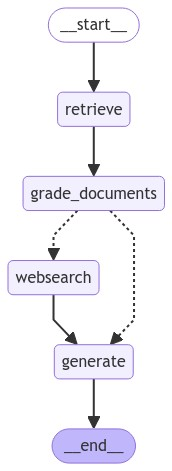

In [125]:
from IPython.display import Image, display

display(Image(workflow_aspect_agent(False,True,"ciano-geppetti",object,object).get_graph().draw_mermaid_png()))

# Master agent

In [115]:
from typing import Annotated
import operator
from langgraph.constants import Send


### Super Graph State
class SuperGraphState(TypedDict):
    """
    Represents the state of our super-graph.
    """
    
    question: str
    aspects: List[str]
    queries: List[str]
    answers_agent: Annotated[List[str], operator.add]
    final_answer: str


def generate_queries(state,verbose,llm):
    """
    Generate multi-aspect queries from the starting question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains the multi aspect queries
    """
    if verbose: 
        print("---GENERATE MULTI-ASPECTS QUERIES---")
        print(f"State: {state}")
    question = state["question"]
    aspects = state["aspects"]

    generation = query_generator(llm).invoke({"original_query": question, "aspects": aspects})
    #print(list(generation.values()))
    return {"queries": eval(generation)}

def send_queries(state,verbose):
    if verbose: 
        print("---SEND MULTI-ASPECTS QUERIES---")
        print(f"State: {state}")
    return [Send("aspect_agent_node", {"query": q, "aspect_id": state["queries"].index(q)}) for q in state["queries"]]

def organize_outputs(state,verbose,llm):
    """
    Organize the outputs of the agents.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, answer, that contains the final answer to give to user
    """
    if verbose:
        print("---ORGANIZE OUTPUTS---")
        print(f"State: {state}")
    answers_agent = state["answers_agent"]

    final_output =final_answer(llm).invoke({"answers": answers_agent})
    return {"final_answer": final_output}

In [116]:
def master_flow(fair_trust,verbose,llm,retriever,retrievers_KBT):
    master_flow = StateGraph(SuperGraphState)

    # Define the nodes
    master_flow.add_node("generate_queries", functools.partial(generate_queries, verbose=verbose, llm=llm))
    master_flow.add_node("organize_queries", functools.partial(organize_outputs, verbose=verbose, llm=llm))
    master_flow.add_node("aspect_agent_node",workflow_aspect_agent(fair_trust,verbose,llm,retriever,retrievers_KBT))

    # Build graph
    master_flow.add_edge(START, "generate_queries")
    master_flow.add_conditional_edges("generate_queries", functools.partial(send_queries, verbose=verbose), ["aspect_agent_node"])
    master_flow.add_edge("aspect_agent_node", "organize_queries")
    master_flow.add_edge("organize_queries", END)

    master_compiled = master_flow.compile()
    return master_compiled

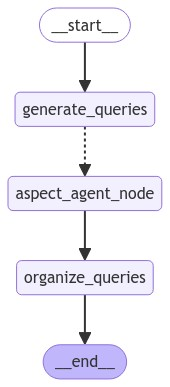

In [117]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(master_flow(True,"ciano-geppetti",object,object).get_graph().draw_mermaid_png()))

# Configuration and app-launching

Configuration of llm

In [100]:
# choosing llm

local_llm = "llama3.1" #"llama3.1:70b"

start_ollama()
pull_model(local_llm)
start_model(local_llm)

Error: listen tcp 127.0.0.1:11434: bind: address already in use


[GIN] 2024/07/31 - 08:17:43 | 200 |      36.548µs |       127.0.0.1 | HEAD     "/"
pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ [GIN] 2024/07/31 - 08:17:44 | 200 |  444.305415ms |       127.0.0.1 | POST     "/api/pull"
pulling manifest 
Error: pull model manifest: file does not exist
[GIN] 2024/07/31 - 08:17:44 | 200 |      31.388µs |       127.0.0.1 | HEAD     "/"
[GIN] 2024/07/31 - 08:17:44 | 200 |   22.554653ms |       127.0.0.1 | POST     "/api/show"
[GIN] 2024/07/31 - 08:17:44 | 200 |   24.190413ms |       127.0.0.1 | POST     "/api/generate"


Creazione vectorstore

In [ ]:
urls = [
    "https://bmjgroup.com/celebrity-tweets-likely-shaped-us-negative-public-opinion-of-covid-19-pandemic/",
    "https://eu.usatoday.com/story/news/health/2024/07/26/covid-vaccine-us-china-propaganda/74555829007/",
    "https://www.theguardian.com/society/2023/jun/13/quarter-in-uk-believe-covid-was-a-hoax-poll-on-conspiracy-theories-finds",
]

#richiede lettura tramite pdf:
# "https://www.ourcommons.ca/Content/Committee/441/HESA/Brief/BR11822476/br-external/LutzMitchell-e.pdf"

retriever = create_vectorstore(urls)

Configurations of aspects, urls of KBTs and question

In [26]:
#aspects and urls_list must be of the same size and ordered for each aspect.
aspects = ["Health","Economy"] #Possible aspects: Health, Economy
urls_list = [["https://www.who.int/emergencies/diseases/novel-coronavirus-2019/covid-19-vaccines",
             "https://www.who.int/news-room/questions-and-answers/item/vaccines-and-immunization-vaccine-safety",
             "https://www.bbc.com/news/stories-52731624",
             "https://www.bbc.com/news/technology-52903680"],
            ["https://www.worldbank.org/en/publication/wdr2022/brief/chapter-1-introduction-the-economic-impacts-of-the-covid-19-crisis"]]

retrievers_KBT = create_KBTs(aspects, urls_list)

In [89]:
inputs = {"question": "What about covid19?", "aspects": aspects}

#if we want print all the process: True
verbose = True 

# if we want to add entailment with KBT, hate speech detection and debiasing module.
fair_trust = True

In [118]:
for output in master_flow(fair_trust,verbose,local_llm,retriever,retrievers_KBT).stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["final_answer"])
answer = value["final_answer"]

---GENERATE MULTI-ASPECTS QUERIES---
State: {'question': 'What about covid19?', 'aspects': ['Health', 'Economy'], 'queries': None, 'answers_agent': [], 'final_answer': None}
[GIN] 2024/07/31 - 08:21:22 | 200 |  971.274324ms |       127.0.0.1 | POST     "/api/chat"
---SEND MULTI-ASPECTS QUERIES---
State: {'queries': ['Symptoms of COVID19', 'Impact on the economy due to COVID19'], 'question': 'What about covid19?', 'aspects': ['Health', 'Economy'], 'answers_agent': []}
'Finished running: generate_queries:'
---RETRIEVE---
State: {'query': 'Symptoms of COVID19', 'aspect_id': 0, 'answers_agent': [], 'my_answer': None, 'web_search': None, 'documents': None, 'documents_kbt': None}
---RETRIEVE---
State: {'query': 'Impact on the economy due to COVID19', 'aspect_id': 1, 'answers_agent': [], 'my_answer': None, 'web_search': None, 'documents': None, 'documents_kbt': None}
---CHECK DOCUMENT RELEVANCE TO QUESTION---
State: {'query': 'Impact on the economy due to COVID19', 'aspect_id': 1, 'answers_ag